In [1]:
# Constants

# values for denormalizing predicted force values
max_emg = 1062.3342501945458
max_force = 312.7

# is using multiple GPUs?
multiple_GPUs = False

# model architecture settings
n_features=1 # number of emg channels
n_sequence=3500 # number of time steps (length of the wave)
n_hidden=16 # number of neurons
n_layers=2 # number of layers
n_classes=1 # number of outputs

# Muscle Role priorities for each goal
goals = {
    "muscle_imbalance": {
        "green": ["target", "stabilizer", "dynamic_stabilizer", "antagonist"],
        "yellow": ["main", "secondary"],
        "red": ["synergist"]
    },
    "load_optimization": {
        "green": ["main", "target"],
        "yellow": ["dynamic_stabilizer", "synergist", "secondary"],
        "red": ["stabilizer", "antagonist"]
    },
    "rehabilitation": {
        "green": ["stabilizer", "dynamic_stabilizer", "antagonist"],
        "yellow": ["target", "secondary"],
        "red": ["main", "synergist"]
    },
    "endurance_training": {
        "green": ["secondary", "stabilizer", "synergist", "dynamic_stabilizer"],
        "yellow": ["target", "main"],
        "red": ["antagonist"]
    },
    "coordination": {
        "green": ["synergist", "stabilizer", "dynamic_stabilizer"],
        "yellow": ["target", "secondary", "main"],
        "red": ["antagonist"]
    }
}

# Function that returns a description for a muscle's role in an exercise
# Roles are Main, Secondary, Target, Synergist, Stabilizer, Dynamic Stabilizer, Antagonist
def describe_muscle_role(muscle_name, role):
    role = role.lower().replace(" ", "_")
    
    descriptions = {
        "main": f"{muscle_name} muscles are the **primary movers** in this exercise, bearing most of the load and generating the main force.",
        "target": f"{muscle_name} muscles are **targeted muscles**, meaning the exercise is designed to train and strengthen them directly.",
        "secondary": f"{muscle_name} muscles play a **supportive role**, assisting the main muscles in completing the movement.",
        "synergist": f"{muscle_name} muscles act as **synergists**, helping the primary muscles coordinate and control the movement.",
        "stabilizer": f"{muscle_name} muscles serves as **stabilizers**, maintaining posture and joint stability throughout the exercise.",
        "dynamic_stabilizer": f"{muscle_name} muscles are **dynamic stabilizers**, working to stabilize one joint while allowing controlled movement in another.",
        "antagonist": f"{muscle_name} muscles are **antagonists**, meaning they work against the main muscle to control or decelerate the movement."
    }

    return descriptions.get(role, f"Role of {muscle_name} muscle in this exercise is unclassified.")

In [ ]:
# Imports
import pandas as pd
import re
import io
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from collections import Counter
from collections import OrderedDict
from scipy.signal import butter, filtfilt
from flask import Flask, request, jsonify

# Device Type
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# Helper Functions

# Helper function to join muscle names correctly and filter out none muscle names
def fix_muscle_names(muscle_string):
    if not isinstance(muscle_string, str):
        return []

    muscle_list = [re.sub(r'\s+', ' ', m).strip() for m in muscle_string.split(',')]
    fixed = []
    skip_next = False

    empty_equivalent_words = [
        "None", 
        "No significant stabilizers", 
        "See comments", 
    ]

    for i in range(len(muscle_list)):
        if skip_next or len(muscle_list[i]) == 0 or muscle_list[i] in empty_equivalent_words:
            skip_next = False
            continue
        if i < len(muscle_list) - 1:
            merged = f"{muscle_list[i]} {muscle_list[i+1]}"
            if re.match(r"Trapezius (Middle|Lower|Upper)", merged, re.IGNORECASE):
                fixed.append(f"{muscle_list[i+1]} Trapezius")
                skip_next = True
                continue
        fixed.append(muscle_list[i])

    return fixed

# Function that prints an array with the occurences of each element
def get_list_details(lst, print_details=True):
    # Convert each array to a tuple so it can be counted
    tuple_list = [tuple(item) for item in lst]
    sorted_list = sorted(Counter(tuple_list).items(), key=lambda x: x[1], reverse=True)

    print('Length of Full List:', len(lst))
    print('Length of Unique List:', len(sorted_list))

    if print_details:
        print('\nDetails:\n')
        for arr_tuple, count in sorted_list:
            print(f"{count}: {list(arr_tuple)}")

    print('\n')

# Function that gets an array of arrays and flattens it getting unique values
def get_array_of_array_unique_values(arrays):
    flattened = [item for sublist in arrays for item in sublist]
    unique_values = list(set(flattened))
    return unique_values

def print_exercises_in_categories(categorized_exercises):
    """
        takes input from function get_categorized_exercises_for_muscle_for_goal()
    """

    for category, roles in some_exercises.items():
        print(f"\n\n+===== {category} =====+")
        if roles:
            for role, exercises_list in roles.items():
                print(f"\n=== {role} ===")
                for exercise in exercises_list:
                    print(exercise)
        else:
            print("No matching exercises.")

def print_exercises_in_roles(roles_exercises):
    """
        prints exercises in a roles exercises array [ {'role1': list}, ... ]
    """
    for role, exercises_list in roles_exercises.items():
        print(f"\n\n+===== {role} =====+")
        for exercise in exercises_list:
            print(exercise)

def print_all_muscles():
    print("\nAll Muscles\n")
    for muscle in all_unique_muscles:
        print(f"{muscle}")

In [4]:
# Function that reads dataset, cleans it and creates the muscle arrays, 7 categories + all unique values
def prepare_arrays():
    df = pd.read_csv('gym_exercise_dataset.csv')
    exercises = df.to_dict(orient='records')
    columns = list(exercises[0].keys())

    target_muscles = []
    synergist_muscles = []
    stabilizer_muscles = []
    antagonist_muscles = []
    dynamic_stabilizer_muscles = []
    main_muscles = []
    secondary_muscles = []

    for exercise in exercises:
        cleaned_target = fix_muscle_names(exercise['target'])
        cleaned_synergist = fix_muscle_names(exercise['synergist'])
        cleaned_stabilizer = fix_muscle_names(exercise['stabilizer'])
        cleaned_antagonist = fix_muscle_names(exercise['antagonist'])
        cleaned_dynamic = fix_muscle_names(exercise['dynamic_stabilizer'])
        cleaned_main = fix_muscle_names(exercise['main'])
        cleaned_secondary = fix_muscle_names(exercise['secondary'])

        # Update the exercise dict
        exercise['target'] = cleaned_target
        exercise['synergist'] = cleaned_synergist
        exercise['stabilizer'] = cleaned_stabilizer
        exercise['antagonist'] = cleaned_antagonist
        exercise['dynamic_stabilizer'] = cleaned_dynamic
        exercise['main'] = cleaned_main
        exercise['secondary'] = cleaned_secondary

        # Append to respective arrays
        if len(cleaned_target) > 0: target_muscles.append(cleaned_target)
        if len(cleaned_synergist) > 0: synergist_muscles.append(cleaned_synergist)
        if len(cleaned_stabilizer) > 0: stabilizer_muscles.append(cleaned_stabilizer)
        if len(cleaned_antagonist) > 0: antagonist_muscles.append(cleaned_antagonist)
        if len(cleaned_dynamic) > 0: dynamic_stabilizer_muscles.append(cleaned_dynamic)
        if len(cleaned_main) > 0: main_muscles.append(cleaned_main)
        if len(cleaned_secondary) > 0: secondary_muscles.append(cleaned_secondary)

    all_muscles = target_muscles + synergist_muscles + stabilizer_muscles + antagonist_muscles + dynamic_stabilizer_muscles + main_muscles + secondary_muscles
    all_flat_muscles = [item for sublist in all_muscles for item in (sublist if isinstance(sublist, list) else [sublist])]
    all_unique_muscles = list(set(all_flat_muscles))

    print('Dataset read successfully!')

    return exercises, all_unique_muscles, target_muscles, synergist_muscles, stabilizer_muscles, antagonist_muscles, dynamic_stabilizer_muscles, main_muscles, secondary_muscles
    

In [5]:
# Function that takes a muscle name and returns exercises that have this muscle name in one of its muscle values, no exercises should be included twice across the whole 7 lists of exercises
def get_exercises_by_muscle(muscle_name):
    matching_exercises = {
        'target': [],
        'synergist': [],
        'stabilizer': [],
        'antagonist': [],
        'dynamic_stabilizer': [],
        'main': [],
        'secondary': []
    }

    for exercise in exercises:
        exercise_name = exercise.get('Exercise Name')
        
        for category in matching_exercises.keys():
            muscle_list = exercise.get(category, [])

            # Ensure muscle_list is not an empty array or NaN
            if isinstance(muscle_list, (pd.Series, list)) and len(muscle_list) == 0:
                continue
            if isinstance(muscle_list, list) or isinstance(muscle_list, pd.Series):
                if pd.isna(muscle_list).any():  # If any value is NaN, continue
                    continue
            elif not isinstance(muscle_list, list):
                muscle_list = [muscle_list]

            if muscle_name.lower() in [m.lower() for m in muscle_list]:
                # Check if the exercise name already exists in the category, if not, add it
                existing_exercise = next((entry for entry in matching_exercises[category] if isinstance(entry, dict) and exercise_name in entry), None)

                if existing_exercise is None:
                    matching_exercises[category].append({exercise_name: [exercise]})
                else:
                    existing_exercise[exercise_name].append(exercise)
                break  # Ensure the exercise is added only once per category

    return matching_exercises

In [6]:
# Function that categorizes exercise into 3 colors (green, yellow, red)
# User should exercise green, be cautious with yellow and avoid red
def get_categorized_exercises_for_muscle_for_goal(muscle_name, goal):
    muscle_exercises = get_exercises_by_muscle(muscle_name)

    # Initialize categories for the goal
    categorized_exercises = {
        "green": {},
        "yellow": {},
        "red": {}
    }

    # Get the muscle role priorities for the goal
    goal_priorities = goals.get(goal, {})

    # Check if the goal exists, otherwise return empty categories
    if not goal_priorities:
        return categorized_exercises

    for priority in goal_priorities:
        for role in goal_priorities[priority]:
            if len(muscle_exercises[role]) > 0:
                categorized_exercises[priority][role] = muscle_exercises[role]

    return categorized_exercises

In [7]:
# Function that gets exercises in { green, yellow, red } and returns the category by option
def get_exercises_by_category(categorized_exercises, green=True, yellow=True, red=False):
    """
        By default return Green U Yellow - Red
    """

    selected = {}
    
    # Build exclusion set from all disabled categories
    exclusion_set = set()
    for color, include in [("green", green), ("yellow", yellow), ("red", red)]:
        if not include:
            for role, exercises in categorized_exercises.get(color, {}).items():
                for ex in exercises:
                    
                    exclusion_set.add(list(ex.keys())[0])

    # Include exercises from only enabled categories, filtering exclusions
    for color, include in [("green", green), ("yellow", yellow), ("red", red)]:
        if include:
            for role, exercises in categorized_exercises.get(color, {}).items():
                for ex in exercises:
                    if list(ex.keys())[0] not in exclusion_set:
                        if role not in selected:
                            selected[role] = []
                        selected[role].append(list(ex.keys())[0])

    return selected

In [8]:
# Model Class
class ClickNet(nn.Module):
    def __init__(self, n_features, n_hidden, n_sequence, n_layers, n_classes):
        super(ClickNet, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_sequence = n_sequence
        self.n_layers = n_layers
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)

        self.linear_1 = nn.Linear(in_features=n_hidden, out_features=128)
        self.dropout_1 = nn.Dropout(p=0.2)
        self.linear_2 = nn.Linear(in_features=128, out_features=n_classes)

    def forward(self, x):
        # Reset hidden state for each batch (no cross-wave memory)
        h_0 = torch.zeros(self.n_layers, x.size(0), self.n_hidden).to(x.device)
        c_0 = torch.zeros(self.n_layers, x.size(0), self.n_hidden).to(x.device)

        out, _ = self.lstm(x.view(x.size(0), self.n_sequence, -1), (h_0, c_0))

        # # Initialize hidden state only if it's None
        # if self.hidden is None:
        #     self.hidden = (
        #         torch.zeros(self.n_layers, x.size(0), self.n_hidden).to(x.device),
        #         torch.zeros(self.n_layers, x.size(0), self.n_hidden).to(x.device)
        #     )

        # out, self.hidden = self.lstm(x.view(x.size(0), self.n_sequence, -1), self.hidden)

        out = self.linear_1(out)
        out = self.dropout_1(out)
        out = self.linear_2(out)

        return out

In [9]:
# Function to load the model
def load_model():
    path_to_model = './model'

    model = ClickNet(n_features, n_hidden, n_sequence, n_layers, n_classes)
    if multiple_GPUs:
        model = nn.DataParallel(model).to(device)
    else:
        model = model.to(device)

    # model = torch.load(path_to_model + '/model.pth')
    state_dict = torch.load(path_to_model + '/model_weights.pth', map_location=torch.device('cpu'))

    # Remove "module." prefix from keys if present
    new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
    model.load_state_dict(new_state_dict)
    model.eval()

    loss_values = np.loadtxt(path_to_model + '/loss_values.txt')
    training_r2_values = np.loadtxt(path_to_model + '/training_r2_values.txt')
    training_rmsd_values = np.loadtxt(path_to_model + '/training_rmsd_values.txt')
    training_accuracy_values = np.loadtxt(path_to_model + '/training_accuracy_values.txt')
    validating_r2_values = np.loadtxt(path_to_model + '/validating_r2_values.txt')
    validating_rmsd_values = np.loadtxt(path_to_model + '/validating_rmsd_values.txt')
    validating_accuracy_values = np.loadtxt(path_to_model + '/validating_accuracy_values.txt')

    print("Loaded Model!")
    print(model)
    return model
model = load_model()

Loaded Model!
ClickNet(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (linear_1): Linear(in_features=16, out_features=128, bias=True)
  (dropout_1): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=128, out_features=1, bias=True)
)


In [10]:
# Functions responsible for getting force wave from emg wave
def get_predicted_force_from_emg(raw_emg_wave, true_force_wave=[], is_plotting=False):
    preprocessed_emg_wave = preprocess_single_data(raw_emg_wave)

    padded = [np.pad(preprocessed_emg_wave[i:i + n_sequence], ((0, max(0, n_sequence - len(preprocessed_emg_wave[i:i + n_sequence]))),) + ((0,) * (preprocessed_emg_wave.ndim - 1)), 'constant')
              for i in range(0, len(preprocessed_emg_wave), n_sequence)]
    preds = [model(torch.tensor(c, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)).detach().cpu().numpy().squeeze(0) for c in padded]
    predicted_force_wave_flattened = np.concatenate(preds, axis=0) if preds else np.array([])
    predicted_force_wave_flattened = predicted_force_wave_flattened[0:len(preprocessed_emg_wave)]
    predicted_force_wave_denormalized = denormalize_force_with_max_force(predicted_force_wave_flattened)
    
    if is_plotting:
        if len(true_force_wave) > 0: plt.plot(true_force_wave, color="#1f77b4", label="true force")
        plt.plot(predicted_force_wave_denormalized, color="orange", label="predicted force")
        plt.legend()
        plt.show()

    return predicted_force_wave_denormalized

def preprocess_single_data(data):
    # apply full wave rectification
    emg_filtered_rectified = full_wave_rectification(data)
 
    # apply low-pass butterworth filter (default)
    emg_filtered_butterworth = low_pass_butterworth_filter(emg_filtered_rectified)
 
    # apply three-order sliding mean filter
    emg_filtered_sliding = three_order_sliding_mean_filter(emg_filtered_butterworth)
 
    # apply normalization
    emg_normalized = emg_filtered_sliding / max_emg
    
    return emg_normalized

# Data preprocessing functions
def full_wave_rectification(data):
    return np.abs(data)

def low_pass_butterworth_filter(data, cutoff=1.5, order=4, fs=1000):
    """
      cutoff (Cutoff Frequency) = 1.5Hz (by default)
      order = 4 (by default)
      fs (Sampling Frequency) = 1000Hz (by default)
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist

    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def three_order_sliding_mean_filter(data):
    window_size = 3
    if data.ndim == 1:
        return np.convolve(data, np.ones(window_size) / window_size, mode='same')
    return np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size) / window_size, mode='same'),
        axis=1,
        arr=data
    )

def denormalize_force_with_max_force(normalized_force):
    return normalized_force * max_force


In [11]:
# This helper function compares the max portion of the 2 waves and checks if the % difference exceeds the threshold 
def compare_peak_values(force_1, force_2, threshold, padding=250):
    peak_index = np.argmax(force_1)
    start = max(0, peak_index - padding)
    end = min(len(force_1), peak_index + padding + 1)

    segment_1 = force_1[start:end]
    segment_2 = force_2[start:end]

    # Create symmetric weights with peak in the center having highest weight
    length = len(segment_1)
    center = length // 2
    weights = np.array([1 / (abs(i - center) + 1)**2 for i in range(length)])
    weights /= weights.sum()  # Normalize weights

    # Avoid division by zero and compute percentage difference relative to max at each point
    max_vals = np.maximum(segment_1, segment_2)
    max_vals[max_vals == 0] = 1e-8  # Avoid division by zero
    percent_diff = np.abs(segment_1 - segment_2) / max_vals

    percent_diff = percent_diff.flatten()
    weights = weights.flatten()

    # Compute weighted average of percentage differences
    weighted_avg_diff = float(np.average(percent_diff, weights=weights))

    return weighted_avg_diff > threshold, weighted_avg_diff

In [12]:
# Function that gets emg from 1 pair of bilateral muscle emg waves, muscle name and outputs if theres a muscle imbalance
# If theres a muscle imbalance recommended exercises are returned along with exercises to avoid and be cautious with
def detect_and_resolve_imbalance_across_bilateral_muscle_pair(left_emg, right_emg, muscle_name, threshold=0.025): # threshold 0.25
    # Step 1: Get predicted force values
    left_force = get_predicted_force_from_emg(left_emg)
    right_force = get_predicted_force_from_emg(right_emg)
    # left_force = force_values_1
    # right_force = force_values_2
    
    # Step 2: Compare peak values
    imbalance_detected, percent_diff = compare_peak_values(left_force, right_force, threshold)

    if imbalance_detected:
        # Step 3: Identify weaker side
        if max(left_force) < max(right_force):
            weaker_side = "left"
        else:
            weaker_side = "right"
        
        # Step 4: Get corrective exercises
        categorized_exercises = get_categorized_exercises_for_muscle_for_goal(muscle_name, goal='muscle_imbalance')
        
        allowed_exercises = get_exercises_by_category(categorized_exercises, green=True, yellow=False, red=False)
        allowed_exercises_with_caution = get_exercises_by_category(categorized_exercises, green=False, yellow=True, red=False)
        not_allowed_exercises = get_exercises_by_category(categorized_exercises, green=False, yellow=False, red=True)

        return {
            "imbalance": True,
            "percent_difference": percent_diff,
            "weaker_muscle": weaker_side + ' ' + muscle_name,
            "recommended_exercises": {
                "allowed_exercises": allowed_exercises,
                "allowed_exercises_with_caution": allowed_exercises_with_caution,
                "not_allowed_exercises": not_allowed_exercises,
            }
        }
    else:
        return {
            "imbalance": False,
            "percent_difference": percent_diff
        }

Dataset read successfully!


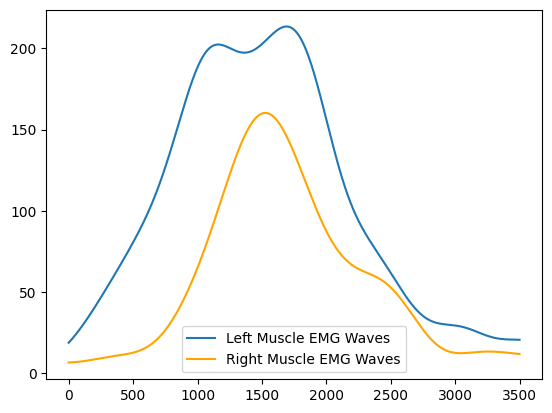

There's a muscle imbalance in the right Upper Trapezius muscle


{'imbalance': True,
 'percent_difference': 0.08696885029345285,
 'weaker_muscle': 'right Upper Trapezius',
 'recommended_exercises': {'allowed_exercises': {'target': ['Shrug',
    'Trap Bar Shrug',
    'Shrug with Stirrups',
    'Seated Shrug',
    'Gripless Shrug',
    'Inverted Shrug'],
   'stabilizer': ['Front Raise',
    'Military Press',
    'Military Press (Seated)',
    'Front Raise (Alternating)',
    'Front Raise (One Arm)',
    'Shoulder Press',
    'Shoulder Press (Seated)',
    'Arnold Press',
    'Shoulder Press (One Arm)',
    'Reclined Shoulder Press',
    'Shoulder Press (Parallel Grip)',
    'Pike Press (between benches)',
    'Pike Press Elevated (between benches)',
    'Upright Row',
    'Lateral Raise',
    'Lateral Raise (One Arm)',
    'Upright Row (One Arm)',
    'Upright Row (with rope)',
    'Y Raise',
    'Incline Lateral Raise',
    'Lateral Raise (other machine)',
    'Upright Row\u200b\u200b\u200b\u200b\u200b\u200b\u200b',
    'Front Lateral Raise',
    'Fu

In [ ]:
# Initialize variables
exercises, all_unique_muscles, target_muscles, synergist_muscles, stabilizer_muscles, antagonist_muscles, dynamic_stabilizer_muscles, main_muscles, secondary_muscles = prepare_arrays()

target_muscles_unique = get_array_of_array_unique_values(target_muscles)
synergist_muscles_unique = get_array_of_array_unique_values(synergist_muscles)
stabilizer_muscles_unique = get_array_of_array_unique_values(stabilizer_muscles)
antagonist_muscles_unique = get_array_of_array_unique_values(antagonist_muscles)
dynamic_stabilizer_muscles_unique = get_array_of_array_unique_values(dynamic_stabilizer_muscles)
main_muscles_unique = get_array_of_array_unique_values(main_muscles)
secondary_muscles_unique = get_array_of_array_unique_values(secondary_muscles)



## --- Playground --- ##
# some_exercises = get_categorized_exercises_for_muscle_for_goal('Upper Trapezius', 'muscle_imbalance')
# some_exercises_allowed = get_exercises_by_category(some_exercises)
# some_exercises_not_allowed = get_exercises_by_category(some_exercises, green=False, yellow=True, red=True)

# print_all_muscles()
# print("\nPrinting Exercises for Upper Trapezius for Muscle Imbalance Resolution...")
# print_exercises_in_roles(some_exercises_allowed)

# print("\nPrinting Exercises for that you should avoid when training Upper Trapezius for Muscle Imbalance Resolution...")
# print_exercises_in_roles(some_exercises_not_allowed)

    
force_left_good = np.load('npy-test-values/force_values_1.npy') + 70
force_left_bad = np.load('npy-test-values/force_values_1.npy') + 60

force_right_good = np.load('npy-test-values/force_values_2.npy')

# force_values_1 = force_left_good
force_values_1 = force_left_bad
force_values_2 = force_right_good

emg_values_1 = np.load('npy-test-values/emg_values_3.npy')
emg_values_2 = np.load('npy-test-values/emg_values_4.npy')
emg_values_3 = emg_values_2 + 30

left_muscle_waves = emg_values_1
right_muscle_waves = emg_values_2

plt.plot(left_muscle_waves, color="#1f77b4", label="Left Muscle EMG Waves")
plt.plot(right_muscle_waves, color="orange", label="Right Muscle EMG Waves")
plt.legend()
plt.show()

result = detect_and_resolve_imbalance_across_bilateral_muscle_pair(left_muscle_waves, right_muscle_waves, 'Upper Trapezius')

if result['imbalance']: print(f"There's a muscle imbalance in the {result['weaker_muscle']} muscle")
if not result['imbalance']: print("There's not a muscle imbalance")
result

In [ ]:
# import numpy as np

# # Load the .npy file
# data = np.load('npy-test-values/emg_values_4.npy')

# # Save to a text file (space-separated values)
# np.savetxt('npy-test-values/emg_values_4.txt', data, fmt='%s')  # use '%s' for general, or '%.6f' for floats

In [ ]:
app = Flask(__name__)

@app.route('/detect_and_resolve_imbalance_across_bilateral_muscle_pair', methods=['POST'])
def detect_and_resolve_imbalance_across_bilateral_muscle_pair_request():
    try:
        emg_left_file = request.files.get('emg_left')
        emg_right_file = request.files.get('emg_right')
        muscle_name = request.form.get('muscle_name')

        if emg_left_file is None or emg_right_file is None or muscle_name is None:
            return jsonify({"error": "Missing data"}), 400

        emg_left_str = emg_left_file.read().decode('utf-8')
        emg_right_str = emg_right_file.read().decode('utf-8')

        emg_left_array = np.loadtxt(io.StringIO(emg_left_str))
        emg_right_array = np.loadtxt(io.StringIO(emg_right_str))

        prediction = detect_and_resolve_imbalance_across_bilateral_muscle_pair(
            emg_left_array, emg_right_array, muscle_name)

        return jsonify(prediction)

    except Exception as e:
        return jsonify({"Error, something went wrong!"}), 500

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0')

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

d:\Bachelor\Misc\Exercise Dataset\venv\lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
